## Using Differential Privacy for privacy-preserving statistical releases

![title](images/researchers.jpeg)

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [199]:
COLOR_1 = "#4CB7A5"
COLOR_2 = "#0198E1"
COLOR_3 = "#DE3163"
COLOR_MAP = "Wistia"

In [8]:
def laplace_mechanism(sensitivity, epsilon):
    return np.random.laplace(loc=0, scale=sensitivity/epsilon)

In [9]:
def gaussian_mechanism(sensitivity, epsilon, delta):
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon
    return np.random.normal(loc=0, scale=sigma)

In [312]:
def percentage_error(true_value, noisy_value):
    return round(abs(true_value - noisy_value)/true_value*100, 2)

In [475]:
def visualise(dp_results, epsilons, errors, ylabel, title, labels, figsize=(10, 6)):
    dp_results = pd.DataFrame(dp_results, index=labels)
    # dp_results = dp_results.set_index('labels')
    
    legend_labels = ['True value']
    for epsilon, error in zip(epsilons, errors):
        legend_labels.append('ε = ' + str(epsilon) + ' : Error = ' + str(round(error, 1)) + '%')

    ax = dp_results.plot.bar(rot=0, figsize=figsize, width=0.8, fontsize=12, colormap = COLOR_MAP)
    # ax.ticklabel_format(style='plain')

    plt.title(title, fontsize=16)
    plt.grid(axis='y', alpha=0.5)
    plt.ylabel(ylabel, fontsize = 14)
    # plt.xlabel("Researchers", fontsize = 14)
    plt.legend(fontsize = 12, labels=legend_labels)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Calulating Queries on Researchers Survey Data

In [401]:
data = pd.read_csv("data/simulated_data.csv")
data_size = len(data)
data.head()

,NRIC,researcher_name,sector,salary,degree
0,T4632965N,Nicole Kallman,Engineering,5016,Bachelors
1,T9804006O,Nancy Gonzales,Healthcare,11830,Post-grad
2,T2934239H,Joseph Rigby,Engineering,8520,Masters
3,S6248584N,Michelle Sheriff,Healthcare,4354,Bachelors
4,G8665162J,Lester Odonnell,Healthcare,6871,Bachelors


#### 1. Counting the number of researchers 

10e-6

In [402]:
true_count = len(data['researcher_name'])
print(f"True count of the researchers: {count}")

True count of the researchers: 1000


As a rule of thumb, sensitivity of **count** query is 1. 

In [403]:
sensitivity = 1 
epsilon = 0.1
noisy_count = true_count + laplace_mechanism(sensitivity, epsilon)
# noisy_count_gauss = count + gaussian_mechanism(sensitivity, epsilon, 10e-3)
print(f"Noisy count of the researchers: {noisy_count} with error: {percentage_error(true_count, noisy_count)}%")
# print(f"Noisy count of the researchers: {noisy_count_gauss} with error: {round(abs(count - noisy_count_gauss)/count*100, 2)}%")

Noisy count of the researchers: 990.5622420088712 with error: 0.94%


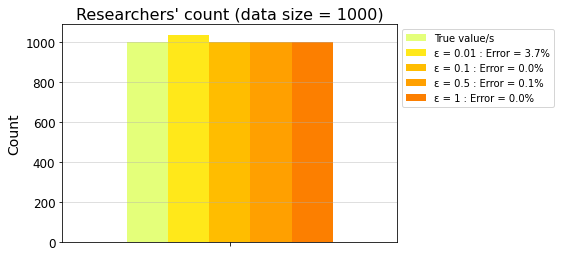

In [471]:
epsilons = [0.01, 0.1, 0.5, 1]
errors = []
dp_results = {}
dp_results["true_count"] = [count]

for epsilon in epsilons:
    noisy_count = count + laplace_mechanism(sensitivity, epsilon)
    dp_results[f"epsilon_{epsilon}"] = [noisy_count]
    errors.append(percentage_error(true_count, noisy_count))

# visualie data 
labels = [""]
title = f"Researchers' count (data size = {data_size})"
ylabel = "Count"
visualise(dp_results, epsilons, errors, ylabel, title, labels, (6, 4))

#### 2. Sum of the researchers' salary 

In [405]:
true_sum_salary = sum(data['salary'])
print(f"True sum of the researchers's salary: {sum_salary}")

True sum of the researchers's salary: 8031772


##### Settings the bounds 

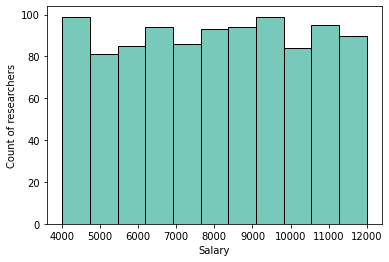

In [406]:
sns.histplot(data['salary'], color=COLOR_1)
plt.xlabel('Salary')
plt.ylabel('Count of researchers');

In [407]:
upper_bound = 6000
lower_bound = 9000
data['bounded_salary'] = data['salary'].clip(lower=lower_bound, upper=lower_bound)

In [408]:
sensitivity = upper_bound 
epsilon = 0.1
noisy_sum_salary = true_sum_salary + laplace_mechanism(sensitivity, epsilon)
print(f"Noisy sum of the researchers's salary: {noisy_sum_salary} with error: {percentage_error(true_sum_salary, noisy_sum_salary)}%")

Noisy sum of the researchers's salary: 8119909.636812566 with error: 1.1%


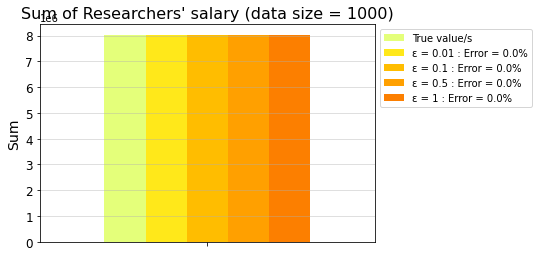

In [473]:
epsilons = [0.01, 0.1, 0.5, 1]
errors = []
dp_results = {}
dp_results["true_sum"] = [true_sum_salary]

for epsilon in epsilons:
    noisy_sum_salary = true_sum_salary + laplace_mechanism(sensitivity, epsilon)
    dp_results[f"epsilon_{epsilon}"] = [noisy_sum_salary]
    errors.append(percentage_error(true_sum_salary, noisy_sum_salary))

# visualie data 
labels = [""]
title = f"Sum of Researchers' salary (data size = {data_size})"
ylabel = "Sum"
visualise(dp_results, epsilons, errors, ylabel, title, labels, (6, 4))

#### 3. Mean of the reserachers' salary (post-processing)

In [416]:
true_mean_salary = sum_salary/count
print(f"True mean of the researchers's salary: {mean_salary}")

True mean of the researchers's salary: 8031.772


In [418]:
noisy_mean_salary = noisy_sum_salary/noisy_count
print(f"Noisy mean of the researchers's salary: {noisy_mean_salary} with error: {percentage_error(true_mean_salary, noisy_mean_salary)}%")

Noisy mean of the researchers's salary: 8054.4954876851725 with error: 0.28%


## Parallel composition 

#### 4. Counting the number of researchers by sector

In [425]:
data['sector'].value_counts().to_frame()

,sector
Agricultural,260
Engineering,257
Healthcare,248
Aerospace,235


In [477]:
sensitivity = 1 
epsilon = 0.5

# This analysis has a total privacy cost of epsilon = 1, even though we release many results!
f = lambda x: x + laplace_mechanism(sensitivity, epsilon)
s = data['sector'].value_counts().apply(f)
s.to_frame().head(5)

,sector
Agricultural,261.977278
Engineering,255.972565
Healthcare,248.699026
Aerospace,231.581765


In [433]:
counts_by_sector_dict = dict(data['sector'].value_counts())

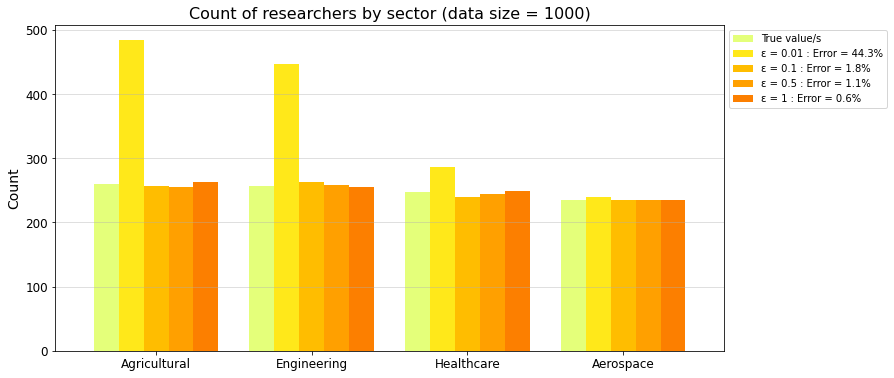

In [474]:
epsilons = [0.01, 0.1, 0.5, 1]
errors = []
dp_results = {}

true_counts_by_sector = counts_by_sector_dict.values()
dp_results["true_counts_by_sector"] = true_counts_by_sector
num_sectors = len(true_counts_by_sector)

for epsilon in epsilons:
    noisy_counts_by_sector = [true_count + laplace_mechanism(sensitivity, epsilon) for true_count in true_counts_by_sector]
    error = sum([percentage_error(tc, nc) for  tc, nc in zip(true_counts_by_sector, noisy_counts_by_sector)])/num_sectors
    dp_results[f"epsilon_{epsilon}"] = noisy_counts_by_sector
    errors.append(error)

# visualie data 
labels = counts_by_sector_dict.keys() #["Aerospace", "Agricultural", "Engineering", "Healthcare"]
title = f"Count of researchers by sector (data size = {data_size})"
ylabel = "Count"
visualise(dp_results, epsilons, errors, ylabel, title, labels, (12, 6))

#### 5. Counting the number of researchers by degree and sector

In [83]:
k = pd.crosstab(data['sector'], data['degree'])

In [87]:
k 

degree,Bachelors,Masters,Non-degree,PhD,Post-grad
sector,,,,,
Aerospace,37,66,47,43,42
Agricultural,58,49,48,52,53
Engineering,52,46,53,54,52
Healthcare,59,47,48,43,51


In [12]:
sensitivity = 1 
epsilon = 0.5

ct = pd.crosstab(data['sector'], data['degree'])
f = lambda x: x + laplace_mechanism(sensitivity, epsilon)
ct.applymap(f)

degree,Bachelors,Masters,Non-degree,PhD,Post-grad
sector,,,,,
Aerospace,37.827867,66.042086,44.997644,43.285872,40.050088
Agricultural,59.793785,47.385290,48.751147,52.083474,52.955827
Engineering,51.909444,48.273811,56.243580,53.551813,46.679244
Healthcare,60.529573,47.440284,46.200875,45.591494,53.366957
